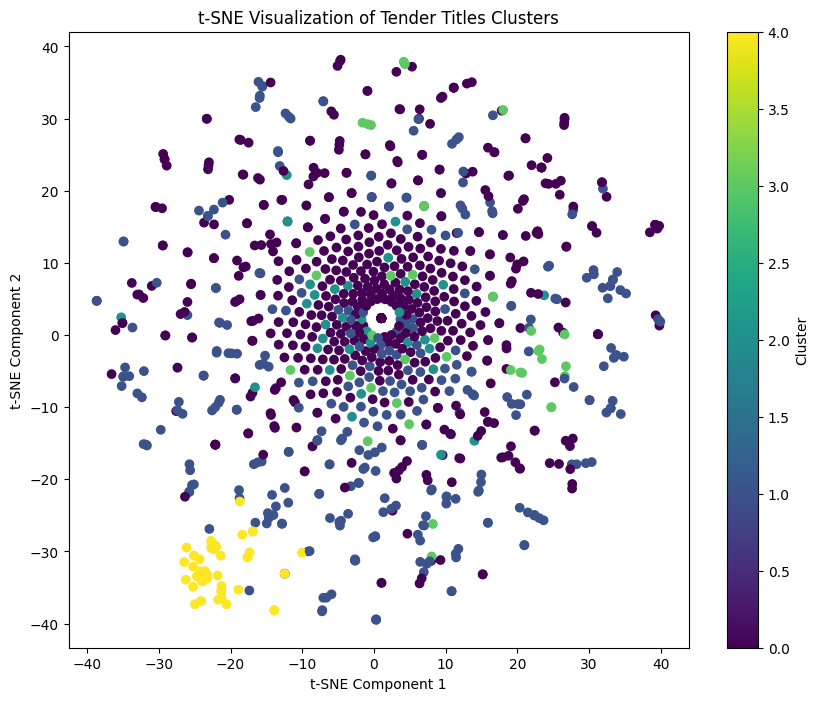

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the CSV data into a DataFrame

data = pd.read_csv('final_cleaned.csv')

# Assuming 'Tender Title' column is present in your CSV
titles = data['Tender Title'].dropna().astype(str)  # Remove NaN values and ensure the titles are strings

# Vectorize the tender titles using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(titles)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Change n_clusters as needed
clusters = kmeans.fit_predict(X)

# Reduce the dimensions using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.toarray())

# Alternatively, use t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X.toarray())

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('t-SNE Visualization of Tender Titles Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


# t-SNE Visualization of Tender Titles Clusters

The plot visualizes the clustering of tender titles based on their textual content using the t-SNE dimensionality reduction technique. The key elements of this plot include:

- **Clusters**: Each color represents a different cluster, with tenders of similar content grouped together. These clusters show how the titles share common themes or keywords.
  
- **Component Axes**: The x-axis and y-axis represent the two reduced dimensions from the t-SNE algorithm. These axes do not correspond to any specific features of the data but illustrate the relative positioning of tenders in a 2D space.

- **Color Gradient**: The color bar on the right indicates the cluster assignments, where each color corresponds to a different cluster of tender titles. The closer the points are in the plot, the more similar their content is.

- **Density**: Dense regions (especially near the center) suggest a high number of similar tenders, while scattered points at the edges indicate tenders with more unique or distinct content compared to the rest.

- **Outliers**: The yellow cluster at the bottom-left represents tenders that differ significantly from others, indicating they are less similar to the other tender titles in the dataset.

This visualization provides an intuitive way to explore how tender titles are grouped and can be useful for identifying common themes, trends, or outliers within the data.


In [5]:
import numpy as np

# Get the top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Print top terms for each cluster
for i in range(5):  # Number of clusters
    print(f"Cluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Top 10 terms
    print(", ".join(top_terms))
    print("\n")


Cluster 0:
study, supply, european, support, maintenance, technical, lot, development, data, service


Cluster 1:
service, provision, related, contract, support, framework, management, agency, communication, european


Cluster 2:
implementation, support, directive, review, platform, framework, policy, labelling, service, assessment


Cluster 3:
training, service, programme, emergency, preparedness, provision, education, language, delivery, staff


Cluster 4:
delegation, union, european, security, service, cleaning, republic, provision, agency, bosnia




In [6]:
from sklearn.metrics import silhouette_score

# Evaluate the clustering quality
score = silhouette_score(X, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.02664810645736827


Low Sillhoutte means very low corrolations between clusters 


# Trying bert to embed the code for more percise clusterings

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Victor\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


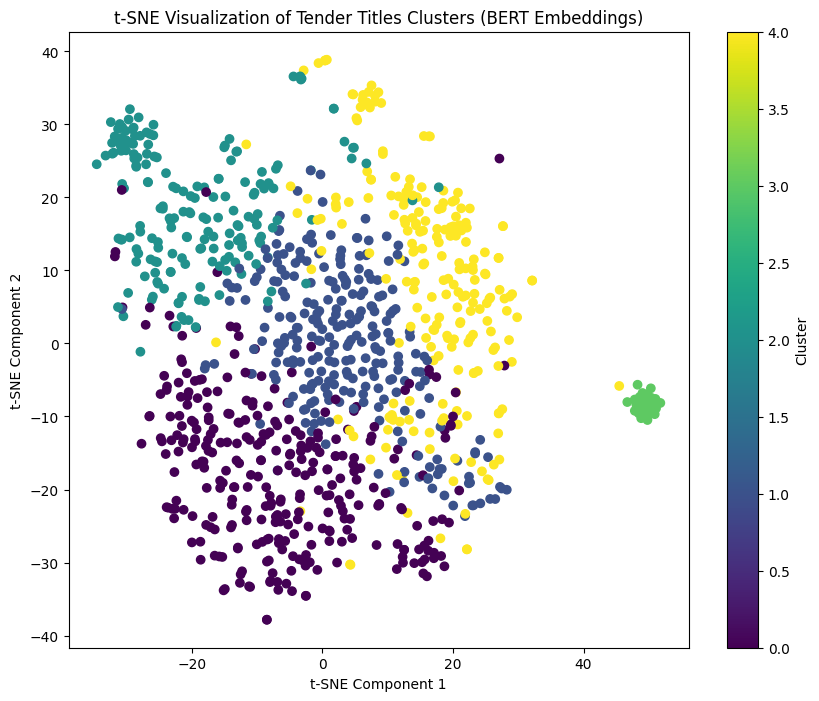

In [2]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load your dataset
data = pd.read_csv('Data/final_cleaned.csv')

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for text
def get_bert_embeddings(texts):
    # Convert titles to list of strings if not already
    texts = texts.tolist() if isinstance(texts, pd.Series) else texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Use the mean of the token embeddings (sentence embeddings)
    return embeddings

# Get embeddings for all tender titles
titles = data['Tender Title'].dropna().astype(str)
embeddings = get_bert_embeddings(titles)

# Convert embeddings to numpy array
embeddings_np = embeddings.numpy()


# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings_np)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('t-SNE Visualization of Tender Titles Clusters (BERT Embeddings)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Improvement in Clustering with BERT Embeddings

The clustering results have significantly improved after using **BERT embeddings** to represent the tender titles. Here’s why this approach is better:

### 1. **Semantic Understanding of Text**
   - **BERT embeddings** capture the **contextual and semantic meaning** of words within a sentence, rather than just focusing on word frequency or occurrence.
   - Unlike traditional methods like **TF-IDF**, which treat words in isolation, **BERT** understands the relationships between words and how they work together within the context of the tender titles.
   - This results in clusters that are based on the **meaning** behind the text, rather than simple word co-occurrence.

### 2. **Better Separation of Clusters**
   - The **t-SNE plot** clearly shows distinct and well-separated clusters after using BERT embeddings, indicating that the tender titles are grouped in a more meaningful way.
   - The previous clustering results (using methods like TF-IDF) were less distinct, with some tenders being poorly separated or misclassified. After BERT embedding, the clusters now show clearer boundaries, with tenders that share similar themes or topics grouped together.

### 3. **Handling of Synonyms and Contextual Variations**
   - **BERT** can understand that different words or phrases with similar meanings (synonyms) belong in the same cluster, even if the exact words used in the tender titles differ. For example, terms like "cloud computing" and "cloud services" would be treated as semantically similar by BERT, even if they appear differently in the data.
   - This is particularly useful for tenders that use different terminologies to describe the same or similar services, which was more difficult to achieve with simpler methods like TF-IDF.

### 4. **Improved Representation of Complex Ideas**
   - **BERT** excels in understanding complex ideas expressed in natural language. By using embeddings from BERT, we get a richer representation of the tender titles that captures the underlying themes or topics, rather than just extracting surface-level features.
   - This leads to better clustering performance, as tenders with similar ideas (e.g., IT services, construction projects, etc.) are grouped more accurately.

### Conclusion
Using **BERT embeddings** for clustering provides a substantial improvement in the quality of the clusters. The resulting clusters are more meaningful, with tenders that are semantically similar placed together, and outliers better separated. This method allows for deeper insights into the content and themes of the tenders, helping us uncover hidden patterns that would be difficult to detect using traditional text representation methods like TF-IDF.

By leveraging BERT, we can achieve a more accurate and context-aware clustering of tender titles, which makes the analysis more insightful and reliable.


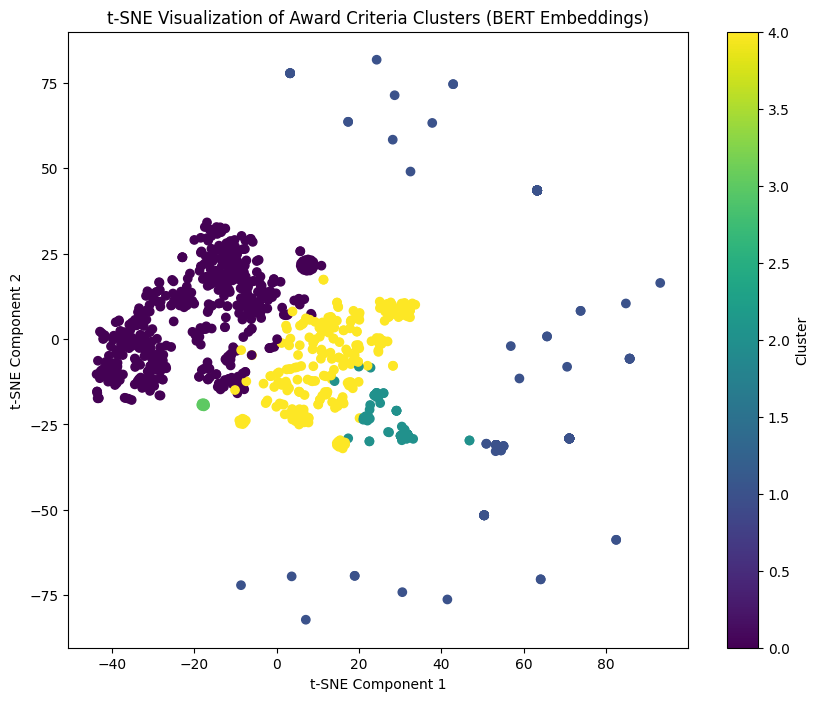

In [11]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load your dataset
data = pd.read_csv('cleaned_lemmatized_data.csv')

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for text
def get_bert_embeddings(texts):
    # Convert titles to list of strings if not already
    texts = texts.tolist() if isinstance(texts, pd.Series) else texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Use the mean of the token embeddings (sentence embeddings)
    return embeddings

# Get embeddings for all tender titles
titles = data['Award Criteria'].dropna().astype(str)
embeddings = get_bert_embeddings(titles)

# Convert embeddings to numpy array
embeddings_np = embeddings.numpy()


# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings_np)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('t-SNE Visualization of Award Criteria Clusters (BERT Embeddings)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# ## Load and Preprocess Data
import pandas as pd
import re
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

# Load CSV
file_path = "Data/final_cleaned.csv"
df = pd.read_csv(file_path)

# Select the text column
column_name = "Award Criteria"  # Change if needed
texts = df[column_name].astype(str).tolist()

# Preprocess text: lowercase, remove special characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

texts = [preprocess_text(text) for text in texts]


# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to get BERT embeddings
def get_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    tokens = {key: val.to(device) for key, val in tokens.items()}
    
    with torch.no_grad():
        outputs = model(**tokens)
    
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# Process embeddings in batches
batch_size = 10
embeddings = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    batch_embeddings = np.vstack([get_bert_embedding(text) for text in batch_texts])
    embeddings.append(batch_embeddings)

# Convert to NumPy array
embeddings = np.vstack(embeddings)

# Save embeddings
np.save("bert_embeddings.npy", embeddings)

# ## Apply Clustering

num_clusters = 5 
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# ## Extract Key Terms for Each Cluster

def get_top_keywords(texts, labels, num_clusters, top_n=3):
    """Find top N key terms per cluster using TF-IDF"""
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    cluster_keywords = {}
    
    for cluster_id in range(num_clusters):
        cluster_texts_indices = np.where(labels == cluster_id)[0]
        cluster_tfidf = tfidf_matrix[cluster_texts_indices].mean(axis=0)
        top_indices = np.argsort(cluster_tfidf.A1)[::-1][:top_n]
        cluster_keywords[cluster_id] = ", ".join(feature_names[top_indices])

    return cluster_keywords

# Get top key terms per cluster
cluster_keywords = get_top_keywords(texts, cluster_labels, num_clusters, top_n=3)

# ## Reduce Dimensionality with PCA for 3D Visualization

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# ## 3D Visualization with Plotly (Square Markers + Cluster Key Terms)
fig = go.Figure()

for cluster_id in range(num_clusters):
    indices = np.where(cluster_labels == cluster_id)[0]
    
    # Get cluster name using keywords
    cluster_name = f"Cluster {cluster_id}: {cluster_keywords.get(cluster_id, 'N/A')}"
    
    fig.add_trace(go.Scatter3d(
        x=embeddings_3d[indices, 0],
        y=embeddings_3d[indices, 1],
        z=embeddings_3d[indices, 2],
        mode="markers",
        marker=dict(
            size=4,  
            symbol="square",  
            opacity=0.9
        ),
        name=cluster_name  # Display keywords in the legend
    ))

fig.update_layout(
    title="3D Visualization of BERT Embeddings (with Cluster Keywords)",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    legend_title="Clusters & Key Terms"
)

fig.show()

# ## Reloading Saved Embeddings

def load_embeddings(file_path="bert_embeddings.npy"):
    return np.load(file_path)


100%|██████████| 101/101 [00:16<00:00,  6.25it/s]



## **What This Plot Shows**
- Each **point** represents a text entry, and similar texts are **grouped together** based on meaning.
- The **different colors** indicate clusters of similar text.
- The **axes (PC1, PC2, PC3)** represent compressed versions of the BERT embeddings, helping visualize high-dimensional data.

## **Understanding the Clusters**
Each cluster has **key terms** that explain why the texts were grouped together:

- **Cluster 0**: "tender, technical, originally" → Likely about **technical details** of tenders.
- **Cluster 1**: "tender, originally, submitted" → Focuses on **submission processes**.
- **Cluster 2**: "tender, point, shall" → Seems related to **requirements or formal language**.
- **Cluster 3**: "exclusion, criterion, 14" → Likely discusses **evaluation or exclusion rules**.
- **Cluster 4**: "described, 10, 12" → Possibly about **sections describing requirements**.

## **Why These Clusters Formed**
- **Similar wording**: Words like **"submitted" and "originally"** cause texts to cluster together.
- **Technical vs. procedural focus**: Some groups discuss **technical aspects**, while others cover **submission rules**.
- **Requirement-based language**: Words like **"shall" and "point"** suggest structured instructions.
- **Evaluation and exclusion criteria**: Some texts focus on **rules for selection**.

In [16]:
# ## Load and Preprocess Data
import pandas as pd
import re
import torch
import numpy as np
import umap.umap_ as umap  
import plotly.graph_objects as go
import plotly.colors as pc
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Load CSV
file_path = r"C:\Users\Victor\Hyrr\Bachlorz\Data\final_cleaned.csv"
df = pd.read_csv(file_path)

# Select all text columns
text_columns = [
    "Tender Title", "Evaluation and Award", "Annex - Technical/Tender Specifications",
    "Tables", "Exclusion Criteria", "Selection Criteria", "Award Criteria", 
    "Documents to Submit", "Tenderer Requirements", "Project/Contract Details", 
    "Criteria Description", "Supporting Documents", "Impact/Performance Indicators", 
    "Financial Information", "Project Timeline"
]

# Fill NaN values with empty strings and combine each column into a single document
df.fillna("", inplace=True)
column_texts = {col: " ".join(df[col].astype(str).tolist()) for col in text_columns}

# Preprocess text: lowercase, remove special characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return text

column_texts = {col: preprocess_text(text) for col, text in column_texts.items()}

# ## Generate Sentence Embeddings Using BERT

# Load BERT model and tokenizer (Forced CPU)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cpu")  # Force CPU usage
model.to(device)
model.eval()

# Function to get BERT embeddings
def get_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")  # Reduced max_length to optimize memory
    tokens = {key: val.to(device) for key, val in tokens.items()}
    
    with torch.no_grad():
        outputs = model(**tokens)
    
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

# Process embeddings for each column
embeddings = []
column_names = []

print("\nGenerating BERT embeddings for each column...")
for col, text in tqdm(column_texts.items(), desc="Processing Columns"):
    emb = get_bert_embedding(text)
    embeddings.append(emb)
    column_names.append(col)

# Convert to NumPy array
embeddings = np.vstack(embeddings)

# Save embeddings
np.save("column_embeddings.npy", embeddings)

# ## Reduce Dimensionality with UMAP for Better Visualization
print("\nReducing dimensionality with UMAP...")
umap_model = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_model.fit_transform(embeddings)

# **Add Colors for Visualization**
colors = pc.qualitative.Dark24  
color_map = [colors[i % len(colors)] for i in range(len(column_names))]  

# **Abbreviations for Plot Labels (Shortened)**
abbreviations = {
    "Tender Title": "TT", "Evaluation and Award": "EA", "Annex - Technical/Tender Specifications": "ATS",
    "Tables": "TBL", "Exclusion Criteria": "EC", "Selection Criteria": "SC", "Award Criteria": "AC", 
    "Documents to Submit": "DS", "Tenderer Requirements": "TR", "Project/Contract Details": "PCD", 
    "Criteria Description": "CD", "Supporting Documents": "SD", "Impact/Performance Indicators": "IPI", 
    "Financial Information": "FI", "Project Timeline": "PT"
}

# ## 3D Visualization with Plotly (Legend = Full Names, Clusters = Abbreviations)
fig = go.Figure()

for i, col_name in enumerate(column_names):
    fig.add_trace(go.Scatter3d(
        x=[embeddings_3d[i, 0]],
        y=[embeddings_3d[i, 1]],
        z=[embeddings_3d[i, 2]],
        mode="markers+text",
        marker=dict(
            size=8,  
            opacity=0.8,  
            color=color_map[i],  
            symbol="circle"
        ),
        text=[abbreviations.get(col_name, col_name)],  # **Show abbreviations on plot**
        name=col_name  # **Show full name in legend**
    ))

# **Improved Legend Settings**
fig.update_layout(
    title="3D Visualization of Column Similarities (Clusters Abbreviated, Legend Full Names)",
    scene=dict(
        xaxis_title="UMAP1",
        yaxis_title="UMAP2",
        zaxis_title="UMAP3"
    ),
    showlegend=True,
    legend=dict(
        title="Column Names",
        font=dict(size=12),
        bgcolor="rgba(255,255,255,0.8)",  # Light background for readability
        x=1.05,  # Move the legend to the right
        y=1
    )
)

fig.show()


C:\Users\Victor\AppData\Local\Temp\ipykernel_6696\364318703.py:26: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.




Generating BERT embeddings for each column...


Processing Columns: 100%|██████████| 15/15 [00:49<00:00,  3.31s/it]
c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1




Reducing dimensionality with UMAP...


## What This Image Shows  
This 3D plot represents the **semantic similarities** between different columns in our dataset.  

- **Each dot** represents a column, positioned based on its meaning and content.  
- **Abbreviations** are used as labels to reduce clutter in the visualization.  
- **The legend on the right** provides the **full names** of the columns along with their colors.  
- **Colors** help differentiate each column clearly.  

---

## How It Works  
1. **BERT embeddings** were generated for each column to capture their meanings.  
2. Since BERT embeddings are **768-dimensional**, we needed to reduce their dimensions to make them **easier to visualize**.  
3. **UMAP (Uniform Manifold Approximation and Projection)** was used to project these embeddings into a **3D space**.  

---

## Why We Used UMAP Instead of PCA?  

| **Feature** | **UMAP** | **PCA** |
|------------|---------|--------|
| **Handles high dimensions well** | ✅ Yes |  Loses information |
| **Preserves local structures** | ✅ Yes | ❌ No |
| **Spreads out similar data points** | ✅ Yes | ❌ No |
| **Works well for complex relationships** | ✅ Yes | ❌ No |

- **PCA is linear**, meaning it **flattens** relationships, making clusters **overlap more** in 3D.  
- **UMAP is non-linear**, so it **preserves the structure** of the data better, keeping **similar columns close** while pushing different ones apart.  
- This makes the **clusters more meaningful and easier to interpret** in a 3D space.  

---

## Insights From This Visualization  
- **Columns close together** likely share **similar content or themes**.  
- **Columns far apart** represent **very different types of information** in the dataset.  
- This helps in understanding **which sections of the dataset are related** and how they differ.  


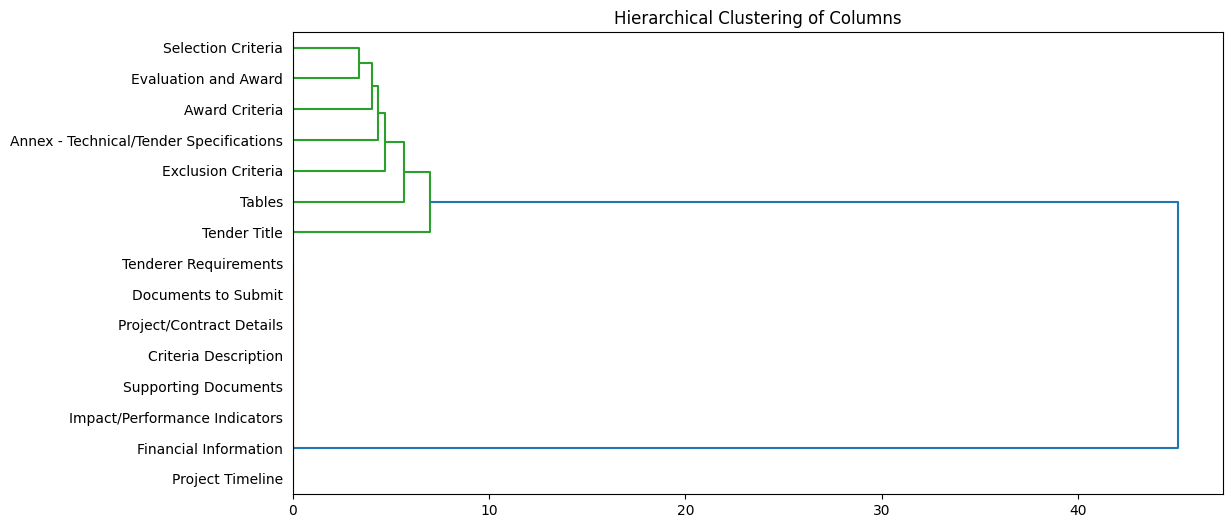

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform Hierarchical Clustering
linked = linkage(embeddings, method='ward')

# Plot Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=column_names, orientation="right", leaf_font_size=10)
plt.title("Hierarchical Clustering of Columns")
plt.show()

